In [224]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [225]:
data = np.array(pd.read_csv("../skgaip/wind/MS_winds.dat", names=list(range(57))))

In [3]:
# Columns = 57 stations
# Rows = wind speed readings (m/s)
data

array([[5.0963, 2.0564, 3.0399, ..., 3.0399, 3.5763, 2.5481],
       [5.0963, 1.5199, 2.5481, ..., 2.5481, 3.5763, 2.5481],
       [5.588 , 1.5199, 2.0564, ..., 2.5481, 3.5763, 1.5199],
       ...,
       [4.6045, 4.0681, 5.0963, ..., 4.6045, 0.    , 3.0399],
       [7.1526, 6.1244, 4.6045, ..., 4.0681, 0.    , 4.0681],
       [7.1526, 3.5763, 3.0399, ..., 4.0681, 0.    , 4.6045]])

In [4]:
# Normalization
# NOTE: This is a bug; they claim this normalizes from 0 to 1, but it doesn't
# NOTE: Their variable also refer to min and max as mean and std, respectively so...
data = (data - data.min()) / data.max()

# Load stored inputs/outputs for verifying

In [5]:
inputs = pickle.load(open("../skgaip/wind/input.pkl", "rb"))
outputs = pickle.load(open("../skgaip/wind/output.pkl", "rb"))
pre = pickle.load(open("../skgaip/wind/pre.pkl", "rb"))
post = pickle.load(open("../skgaip/wind/post.pkl", "rb"))
minmax = pickle.load(open("../skgaip/wind/minmax.pkl", "rb"))
models = pickle.load(open("../skgaip/wind/models.pkl", "rb"))["models"]

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



# Verify inputs

In [8]:
from timecast.utils.ar import historify

historified = historify(jnp.asarray(data), num_histories=8375, history_len=12).reshape(8375, 12, 57)
onp.testing.assert_array_almost_equal(historified, inputs["result"])
onp.testing.assert_array_almost_equal(historified[:6000], inputs["X_train"])
onp.testing.assert_array_almost_equal(data[12:6012,:], inputs["y_train"])
onp.testing.assert_array_almost_equal(historified[6000:6361], inputs["xTest"])
onp.testing.assert_array_almost_equal(data[6012:6373,:], inputs["yTest"])

# Verify predictions

In [9]:
# Mostly from https://github.com/amirstar/Deep-Forecast/blob/4dcdf66f8ae3070ab706b30a6e3cf888f36e0536/multiLSTM.py#L210
def predict(X, models):
    results = onp.zeros_like(onp.zeros((X.shape[0], X.shape[2])))
    
    for ind in range(len(X)):
        modelInd = ind % 6
        if modelInd == 0:
            testInputRaw = X[ind]
            testInputShape = testInputRaw.shape
            testInput = onp.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
        else:
            testInputRaw = onp.vstack((testInputRaw, results[ind-1]))
            testInput = onp.delete(testInputRaw, 0, axis=0)
            testInputShape = testInput.shape
            testInput = onp.reshape(testInput, [1, testInputShape[0], testInputShape[1]])
    
        pred = models[modelInd].predict(testInput)
        results[ind] = pred

    return results

In [10]:
pred = predict(inputs["xTest"], models)

In [11]:
onp.testing.assert_array_almost_equal(pred, outputs["pred"])

In [12]:
test_true = data[6012:6373,:] * minmax["max"] + minmax["min"]
test_pred = outputs["pred"] * minmax["max"] + minmax["min"]
jnp.absolute(test_true - test_pred).mean(axis=0).mean()

DeviceArray(1.1508132, dtype=float32)

In [226]:
test_true

array([[6.6162, 1.5199, 4.0681, ..., 1.5199, 2.0564, 3.5763],
       [4.6045, 1.5199, 2.5481, ..., 1.5199, 2.0564, 2.5481],
       [5.0963, 1.5199, 2.5481, ..., 2.5481, 2.0564, 4.0681],
       ...,
       [6.6162, 2.0564, 2.0564, ..., 2.0564, 4.0681, 2.0564],
       [6.6162, 1.5199, 1.5199, ..., 1.5199, 4.0681, 1.5199],
       [6.1244, 1.5199, 2.0564, ..., 1.5199, 7.6444, 2.5481]])

# Predict all data

In [13]:
historified.shape

(8375, 12, 57)

In [14]:
pred = predict(historified, models)

In [15]:
pred.shape

(8375, 57)

In [16]:
historified.shape

(8375, 12, 57)

In [17]:
true = data[12:]

In [18]:
true.shape

(8375, 57)

In [19]:
jnp.absolute(true - pred).mean(axis=0).mean()

DeviceArray(0.04184432, dtype=float32)


# Train AR

In [20]:
num_train = 6000
history_len = 12
num_stations = 57

In [179]:
from timecast.learners import AR
from timecast.utils.ar import compute_gram, fit_gram

X = data[0:num_train - 1, :num_stations]
Y = data[1:num_train, :num_stations]

num_histories = X.shape[0] - history_len + 1
historified = historify(X, num_histories=num_histories, history_len=history_len).reshape(num_histories, history_len, -1)
pred = predict(historified, models)
Y_lstm = pred[:num_train]

Y = jax.ops.index_add(Y, jax.ops.index[history_len - 1:], -Y_lstm)

In [211]:
XTX, XTY = compute_gram([(X, Y, None)], num_stations, num_stations, history_len)

In [212]:
fit_intercept = True
feature_dim = XTX.feature_dim
output_dim = XTY.output_dim
input_dim = num_stations

XTX = XTX.matrix(fit_intercept=True, input_dim=input_dim)
XTY = XTY.matrix(fit_intercept=True, input_dim=input_dim)

In [213]:
from timecast.utils.ar import _compute_xtx_inverse, _fit_unconstrained, _form_constraints, _fit_constrained

In [214]:
inv = _compute_xtx_inverse(XTX, 1.0)

In [215]:
inv.shape

(741, 741)

In [216]:
beta = _fit_unconstrained(inv, XTY)

In [217]:
beta.shape

(741, 57)

In [218]:
R, r = _form_constraints(input_dim, output_dim, history_len)

In [219]:
print(R.shape, r.shape)

(728, 741) (728, 57)


In [220]:
beta = _fit_constrained(beta, inv, R, r)

In [221]:
beta.shape

(741, 57)

In [223]:
beta.take(jnp.arange(0, len(beta), input_dim), axis=0)

DeviceArray([[-1.79857947e-04,  2.14874744e-04,  3.53570096e-04,
               2.50877347e-05, -2.79155211e-05,  2.26654112e-04,
               1.21138059e-04, -2.25109980e-05,  9.28444788e-05,
               3.37623060e-05, -6.00827625e-05,  1.00600533e-04,
               1.83505937e-04,  2.95694917e-05,  1.03195198e-04,
              -7.41006806e-06,  1.50304288e-04,  7.83167779e-05,
               2.08432786e-04,  1.80986710e-04, -3.50810587e-05,
               2.88486772e-05,  1.97978952e-04,  2.82486435e-04,
              -6.75208867e-05,  1.54739246e-05, -6.55837357e-06,
              -2.66511925e-05,  5.20972535e-05,  2.42129900e-04,
               1.54385343e-05,  5.67696989e-05,  5.93860168e-05,
              -3.12058255e-05,  3.43936495e-04, -1.28853600e-04,
               1.34454109e-04,  1.61763281e-04,  1.60990283e-04,
               6.70743175e-05, -3.93316150e-05,  2.13257968e-04,
               4.30658692e-05,  5.65255759e-05,  6.26426190e-05,
               2.20472924

In [193]:
ar, state = AR.fit(data=[(X, Y, None)],
                   input_dim=num_stations,
                   output_dim=num_stations,
                   history=data[num_train:num_train + history_len, :num_stations],
                   history_len=history_len,
                   constrain=True
                  )

In [197]:
ar.params["linear"]["kernel"].shape

(12, 57)

In [203]:
ar.params["linear"]["bias"].shape

(57,)

In [207]:
with flax.nn.stateful(state) as state:
    a = ar(onp.random.rand(1, 57))

(12, 57)


In [209]:
a.shape

(57, 57)

In [164]:
window_len = 10
input_dim = 5
output_dim = 4

history = onp.random.rand(window_len + 1, input_dim)
params = onp.random.rand(window_len + 1, output_dim)

history[:, :1] = 1

In [168]:
history = onp.random.rand(window_len, input_dim)
params = onp.random.rand(window_len, output_dim)

In [171]:
squeeze = history.ndim == 2
if squeeze:
    history = history[onp.newaxis, :]
shape = history.shape

X = onp.hstack((onp.ones((shape[0], shape[-1])), history.reshape(shape[0], -1))).reshape(
            shape[0], shape[1] + 1, shape[2]
        )

In [172]:
history

array([[[0.12953213, 0.65651736, 0.52415221, 0.56597917, 0.78822108],
        [0.42495363, 0.81309645, 0.00758129, 0.84521809, 0.90959941],
        [0.47100065, 0.48389782, 0.41067303, 0.61860461, 0.83015928],
        [0.63146769, 0.78199271, 0.63495679, 0.2554679 , 0.30066688],
        [0.66260527, 0.10591973, 0.84142026, 0.25908913, 0.18862932],
        [0.95961316, 0.54093224, 0.85035306, 0.17365682, 0.7710638 ],
        [0.73895243, 0.34623325, 0.61672512, 0.98955749, 0.97833722],
        [0.31442267, 0.88343855, 0.59904268, 0.09723954, 0.28219299],
        [0.97297495, 0.20082004, 0.72395013, 0.07029589, 0.49986498],
        [0.74594147, 0.33441541, 0.20292088, 0.99199407, 0.2630319 ]]])

In [176]:
X = X.squeeze()

In [177]:
X.T @ X

array([[5.32588161, 3.72002657, 4.53887326, 3.79366697, 4.42864931],
       [3.72002657, 4.29414074, 3.55063279, 3.45369146, 4.10735514],
       [4.53887326, 3.55063279, 4.58218652, 3.00571747, 3.95393402],
       [3.79366697, 3.45369146, 3.00571747, 4.55761873, 4.27967576],
       [4.42864931, 4.10735514, 3.95393402, 4.27967576, 5.21417633]])

In [165]:
history.T @ history

array([[11.        ,  5.74121952,  4.77457614,  4.56314291,  6.51857562],
       [ 5.74121952,  3.89880471,  2.6700967 ,  2.48997089,  3.68854703],
       [ 4.77457614,  2.6700967 ,  2.65012103,  1.93280099,  2.8468714 ],
       [ 4.56314291,  2.48997089,  1.93280099,  2.29654228,  2.74359955],
       [ 6.51857562,  3.68854703,  2.8468714 ,  2.74359955,  4.65965208]])

In [167]:
history

array([[1.        , 0.20305233, 0.09925145, 0.30611163, 0.86004327],
       [1.        , 0.58264878, 0.49944466, 0.10621039, 0.88323881],
       [1.        , 0.96316462, 0.33533885, 0.37819474, 0.76708363],
       [1.        , 0.70183326, 0.52226119, 0.37257221, 0.54934271],
       [1.        , 0.23114224, 0.45824865, 0.40249142, 0.51718696],
       [1.        , 0.23103729, 0.31242413, 0.2199189 , 0.04711775],
       [1.        , 0.54463779, 0.78529727, 0.21447287, 0.3295622 ],
       [1.        , 0.07429341, 0.45040237, 0.6409369 , 0.42701988],
       [1.        , 0.78931141, 0.87701925, 0.59053344, 0.96988586],
       [1.        , 0.87965436, 0.30327795, 0.72547767, 0.40223489],
       [1.        , 0.54044404, 0.13161038, 0.60622274, 0.76585964]])

In [148]:
history.copy()

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.00759571, 0.34453576, 0.300451  , 0.92959265, 0.12071304],
       [0.92255528, 0.04321984, 0.90297285, 0.00670791, 0.61806802],
       [0.49844043, 0.25166712, 0.83269117, 0.24525024, 0.91682553],
       [0.25671528, 0.22936977, 0.47296176, 0.91319353, 0.60093712],
       [0.47880951, 0.97465263, 0.68665361, 0.96202754, 0.25017565],
       [0.29204489, 0.55508675, 0.8272032 , 0.62596784, 0.26617962],
       [0.72686184, 0.41732075, 0.94320917, 0.2050314 , 0.62131166],
       [0.65460689, 0.9504738 , 0.08512032, 0.79558665, 0.56484618],
       [0.94808835, 0.07973104, 0.25690551, 0.50877586, 0.13978427],
       [0.38854365, 0.76105638, 0.41855952, 0.73282084, 0.60100032]])

In [140]:
history.T @ params

array([[3.14516113, 3.21383407, 3.46364547, 3.38409544],
       [2.93982427, 2.28515577, 2.77046148, 3.44684157],
       [2.71464741, 3.750229  , 3.22392978, 3.23798499],
       [3.5315933 , 2.92152322, 3.15562877, 4.44815941],
       [2.50455722, 3.0294427 , 3.03158458, 3.14155511]])

In [141]:
history

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.00759571, 0.34453576, 0.300451  , 0.92959265, 0.12071304],
       [0.92255528, 0.04321984, 0.90297285, 0.00670791, 0.61806802],
       [0.49844043, 0.25166712, 0.83269117, 0.24525024, 0.91682553],
       [0.25671528, 0.22936977, 0.47296176, 0.91319353, 0.60093712],
       [0.47880951, 0.97465263, 0.68665361, 0.96202754, 0.25017565],
       [0.29204489, 0.55508675, 0.8272032 , 0.62596784, 0.26617962],
       [0.72686184, 0.41732075, 0.94320917, 0.2050314 , 0.62131166],
       [0.65460689, 0.9504738 , 0.08512032, 0.79558665, 0.56484618],
       [0.94808835, 0.07973104, 0.25690551, 0.50877586, 0.13978427],
       [0.38854365, 0.76105638, 0.41855952, 0.73282084, 0.60100032]])

In [146]:
history[1:,:].T @ params[1:,:] + history[:1,:].T @ params[:1,:]

array([[3.14516113, 3.21383407, 3.46364547, 3.38409544],
       [2.93982427, 2.28515577, 2.77046148, 3.44684157],
       [2.71464741, 3.750229  , 3.22392978, 3.23798499],
       [3.5315933 , 2.92152322, 3.15562877, 4.44815941],
       [2.50455722, 3.0294427 , 3.03158458, 3.14155511]])

In [120]:
history.T @ params

array([[4.11966897, 5.03062521, 6.06840131, 7.23684307],
       [1.85732911, 2.52061872, 2.94872954, 3.33578479],
       [1.95450698, 2.57138923, 2.73787468, 3.90112358],
       [2.06014336, 2.36086602, 2.66676753, 3.04287698],
       [2.01172359, 2.63255346, 2.53000718, 3.43566529]])

In [128]:
history[:,1:].T @ params[:,1:] + history[:,:1].T @ params[:,:1]

array([[6.64028769, 7.06839851, 7.45545376],
       [6.6910582 , 6.85754365, 8.02079255],
       [6.48053498, 6.7864365 , 7.16254595],
       [6.75222242, 6.64967614, 7.55533425]])

In [134]:
history[:,1:].T.shape

(4, 11)

In [135]:
params[:,1:].shape

(11, 3)

In [133]:
history[:,:1].T.shape

(1, 11)

In [132]:
params[:,:1].shape

(11, 1)

In [125]:
params[:,0]

array([0.09803314, 0.58574837, 0.01391095, 0.27981044, 0.90704878,
       0.31706613, 0.3100967 , 0.00129803, 0.33788356, 0.64221236,
       0.62656049])

In [105]:
Y

array([[0.42068758, 0.54737382, 0.12675664, 0.14611476],
       [0.4709953 , 0.85097928, 0.10922268, 0.06769183],
       [0.8280596 , 0.89515511, 0.14045333, 0.42267773],
       [0.37588989, 0.19837924, 0.74596628, 0.09593247],
       [0.18164374, 0.84992791, 0.34330322, 0.86721748],
       [0.84650752, 0.44790673, 0.77586301, 0.03238161],
       [0.41814635, 0.74315361, 0.32349598, 0.72104071],
       [0.93117608, 0.31449077, 0.03734102, 0.20820312],
       [0.68583146, 0.48315091, 0.91073202, 0.43066621],
       [0.78040345, 0.63598218, 0.80139529, 0.0247594 ],
       [0.01669127, 0.41816678, 0.22002194, 0.76491623]])

In [332]:
from timecast.learners import Sequential, Parallel, Index, PCR, AR
from timecast import smap
from timecast.objectives import residual
from timecast.optim import GradientDescent

import tqdm.notebook as tqdm

history_len = 12
num_stations = 57

X = data[num_train + history_len + 0:6373 - 1, :num_stations]
Y = data[num_train + history_len + 1:6373 - 0, :num_stations]

lstm = Index.partial(index=0)
# ar = AR.partial(output_dim=num_stations, history_len=history_len, history=X[:history_len, :num_stations])
ars = Sequential.partial(learners=[Index.partial(index=1), ar.module])
model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ars])
model.params["1"]["ar"] = ar.params

optim_def = GradientDescent(learning_rate=(10 ** -30))
optimizer = optim_def.create(model)

Y_lstm = outputs["pred"][1:, :num_stations]
Y_hat, optimizer, state = smap((Y_lstm, X), Y, optimizer, state=state, objective=residual)

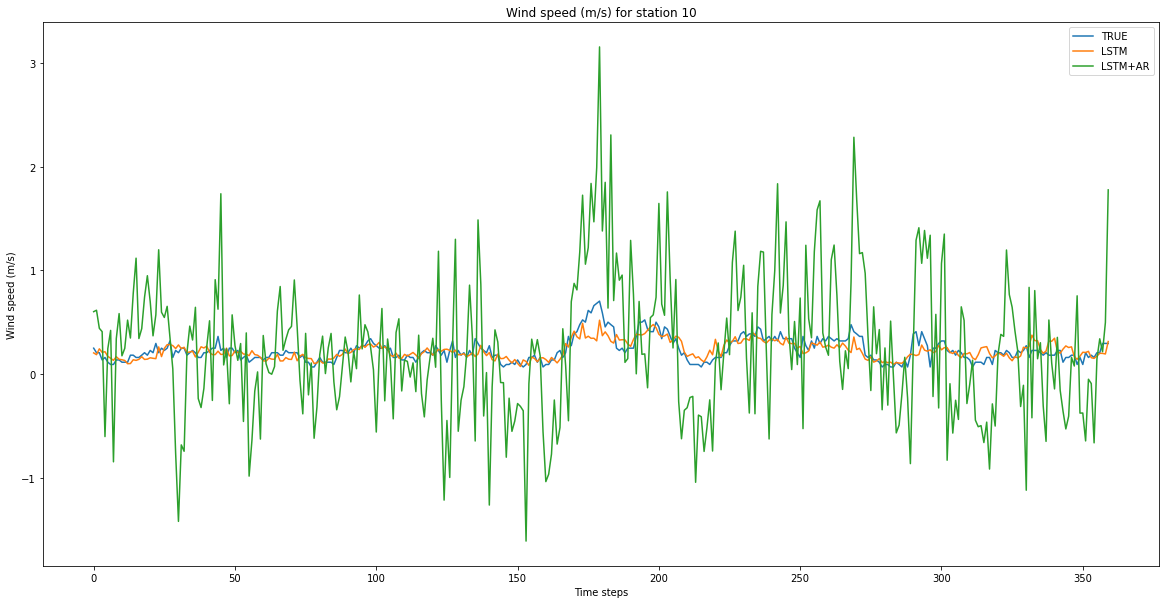

In [336]:
station = 10
plt.plot(Y[:, station], label="TRUE")
plt.plot(Y_lstm[:, station], label="LSTM")
plt.plot(Y_hat[:, station], label="LSTM+AR")
plt.title("Wind speed (m/s) for station {}".format(station))
plt.xlabel("Time steps")
plt.ylabel("Wind speed (m/s)")
plt.legend()

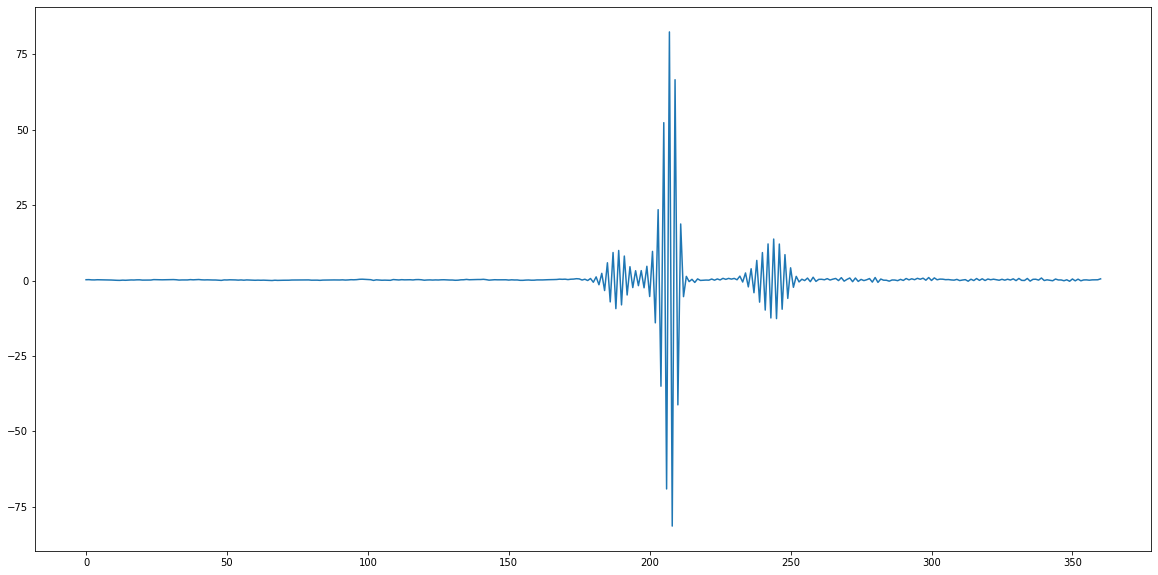

In [169]:
plt.plot(Y_hat[:, 0])